In [1]:

from math import exp, log

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.special import expit

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%matplotlib inline 

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

np.seterr(divide='ignore', invalid='ignore')
np.random.seed(42)

$\mathbf{E}(t_{recovery}) = \exp(2+0.5\cdot{}I_{male}+0.03\cdot{}age+2\cdot{}severity-1\cdot{}I_{medication}),$

In [31]:
def recovery(sex, age, severity, medication):
    return exp(2 + 0.5*sex + 0.03*age + 2*severity - medication)
def rvs_recovery(sex, age, severity, medication, *args):
    return stats.poisson.rvs(recovery(sex, age, severity, medication))
    

In [32]:
N = 10000
random_state = 10
sexes = stats.bernoulli.rvs(0.5, loc=0, size=N, random_state=random_state)
ages = stats.gamma(8, scale = 4).rvs(size=N, random_state=random_state)
severity = stats.beta(3, 1.5).rvs(size=N, random_state=random_state)
mediation = stats.bernoulli.rvs(0.5, loc=0, size=N, random_state=random_state)


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Uniform Distribution ')]

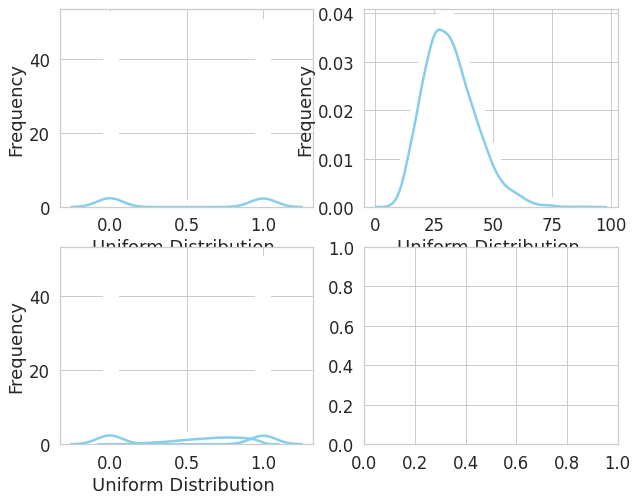

In [33]:
f, axes = plt.subplots(2, 2)
ax = sns.distplot(sexes,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1}, ax=axes[0,0])
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

ax = sns.distplot(ages,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1}, ax=axes[0,1])
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

ax = sns.distplot(severity,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1}, ax=axes[1,0])
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

ax = sns.distplot(mediation,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1}, ax=axes[1,0])
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

In [34]:
const = np.ones(N)
df_rnd = pd.DataFrame(dict(sex=sexes, age=ages, severity=severity, medication=mediation, const=const))
features = ['sex', 'age', 'severity', 'medication', 'const']
df_rnd = df_rnd[features] # to enforce column order
df_rnd['recovery'] = df_rnd.apply(lambda x: rvs_recovery(*x) , axis=1)
df_rnd.head()

,sex,age,severity,medication,const,recovery
0,1,47.905143,0.721040,1,1.0,75
1,0,39.290484,0.874226,0,1.0,120
2,1,38.075851,0.708099,1,1.0,55
3,1,23.362747,0.533345,1,1.0,29
4,0,33.702337,0.640458,0,1.0,70


## Randomized

In [40]:
## X,T => outcome 
glm = sm.GLM(df_rnd['recovery'], df_rnd[features], family=sm.families.Poisson())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9996
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34327.
Date:                Sat, 23 May 2020   Deviance:                       9885.6
Time:                        10:53:33   Pearson chi2:                 9.85e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex           -0.2486      0.001   -197.422      0.000      -0.251      -0.246
age            0.0300   9.64e-05    310.922      0.000       0.030       0.030
severity       1.9984      0.007    291.364      0.000       1.985       2.012
medication    -0.2486      0.001   -197.422      0.000      -0.251      -0.246
const          2.0011      0.006    315.938      0.000       1.989       2.014
==============================================================================
"""

In [51]:
reg = RandomForestRegressor()
X = df_rnd[features].values
y = df_rnd['recovery'].values
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [52]:
X_neg = np.copy(X)
# set the medication column to 0
X_neg[:, df_rnd.columns.get_loc('medication')] = 0
X_pos = np.copy(X)
# set the medication column to 1
X_pos[:, df_rnd.columns.get_loc('medication')] = 1

preds_rnd = res.predict(X_pos) / reg.predict(X_neg)

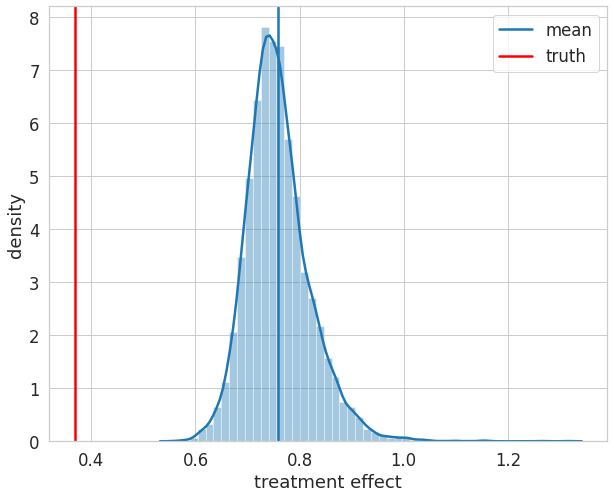

In [53]:
ax = sns.distplot(preds_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_rnd), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

## Non randomized

In [54]:
def get_medication(sex, age, severity, medication, *args):
    return int(1/3*sex + 2/3*severity + 0.15*np.random.randn() > 0.8)

In [55]:
df_obs = df_rnd.copy().drop('recovery', axis=1)
df_obs['medication'] = df_obs.apply(lambda x: get_medication(*x), axis=1)
df_obs['recovery'] = df_obs.apply(lambda x: rvs_recovery(*x), axis=1)
df_obs.describe()

,sex,age,severity,medication,const,recovery
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,0.490900,31.920004,0.666300,0.245400,1.0,84.901300
std,0.499942,11.230024,0.200772,0.430346,0.0,52.601213
min,0.000000,5.684881,0.026154,0.000000,1.0,8.000000
25%,0.000000,23.849306,0.526909,0.000000,1.0,50.000000
50%,0.000000,30.689865,0.691212,0.000000,1.0,73.000000
75%,1.000000,38.695220,0.828244,0.000000,1.0,106.000000
max,1.000000,92.412730,0.999321,1.000000,1.0,660.000000


## Inverse probability of treatment weighting¶


In [58]:
# classifier to estimate the propensity score
cls = LogisticRegression(random_state=42)
#cls = GaussianNB()  # another possible propensity score estimator

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X = df_obs[features].drop(['medication'], axis=1).values
y = df_obs['medication'].values
cls.fit(X, y)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=42,
                                                         solver='lbfgs',
                                                         tol=0.0001, verbose=0,
                                                

In [59]:
propensity = pd.DataFrame(cls.predict_proba(X))
propensity.head()

,0,1
0,0.467464,0.532536
1,0.936345,0.063655
2,0.488730,0.511270
3,0.777427,0.222573
4,0.988287,0.011713


In [64]:
?propensity.lookup

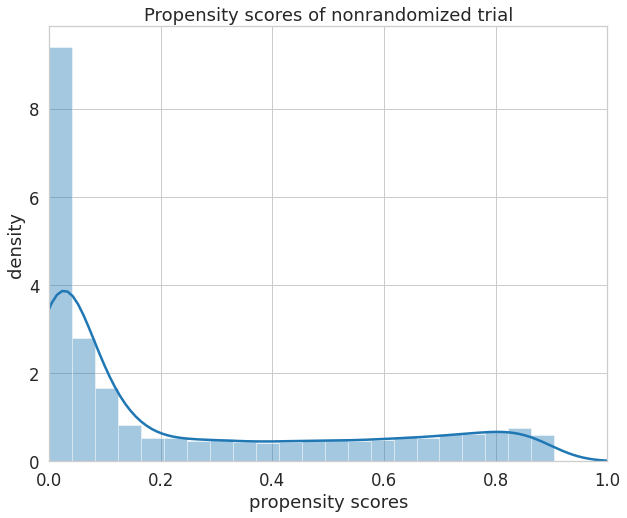

In [60]:
ax = sns.distplot(propensity[1].values)
ax.set_xlim(0, 1)
ax.set_title("Propensity scores of nonrandomized trial")
ax.set_xlabel("propensity scores")
ax.set_ylabel('density');

In [65]:
np.arange(propensity.shape[0])

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [66]:
df_obs['medication']

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    1
Name: medication, Length: 10000, dtype: int64

In [61]:
df_obs['iptw'] = 1. / propensity.lookup(np.arange(propensity.shape[0]), df_obs['medication'])


In [67]:
glm = sm.GLM(df_obs['recovery'], df_obs[features], 
             family=sm.families.Poisson(),
             freq_weights=df_obs['iptw'])
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                 18140.43
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63543.
Date:                Sat, 23 May 2020   Deviance:                       18587.
Time:                        11:07:00   Pearson chi2:                 1.85e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.4995      0.002    290.750      0.000       0.496       0.503
age            0.0300   6.43e-05    467.143      0.000       0.030       0.030
severity       1.9966      0.005    417.578      0.000       1.987       2.006
medication    -1.0031      0.002   -525.354      0.000      -1.007      -0.999
const          2.0001      0.004    448.767      0.000       1.991       2.009
==============================================================================
"""

In [69]:
reg = RandomForestRegressor(random_state=42)
X = df_obs[features].values
y = df_obs['recovery'].values
reg.fit(X, y, sample_weight=df_obs['iptw'].values)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [70]:
X_neg = np.copy(X)
X_neg[:, df_obs.columns.get_loc('medication')] = 0
X_pos = np.copy(X)
X_pos[:, df_obs.columns.get_loc('medication')] = 1

preds_propensity = reg.predict(X_pos) / reg.predict(X_neg)

In [3]:
import numpy as np
np.exp(-1)

0.36787944117144233

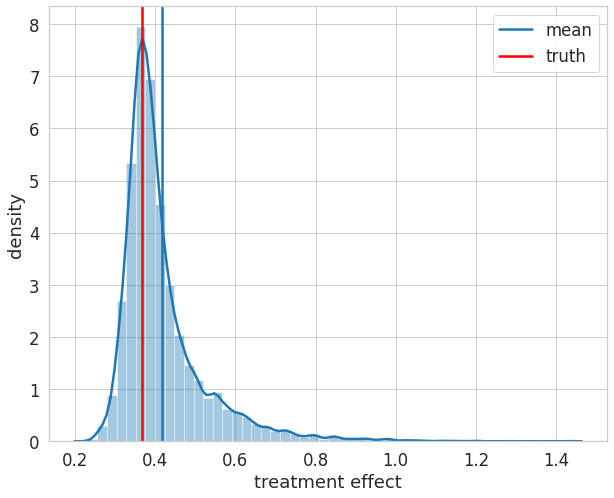

In [71]:
ax = sns.distplot(preds_propensity)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_propensity), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

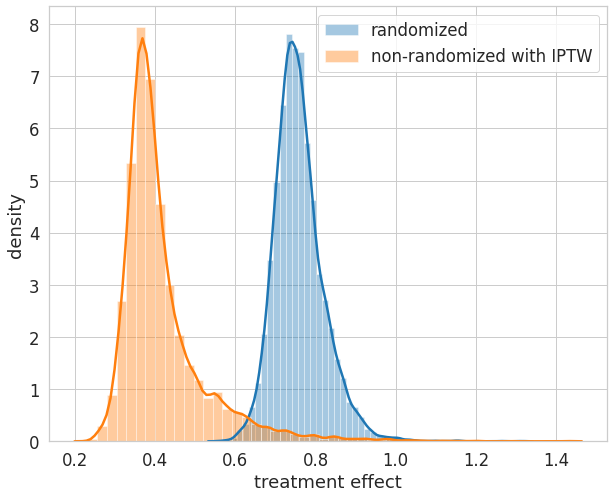

In [72]:
sns.distplot(preds_rnd, label='randomized')
ax = sns.distplot(preds_propensity, label='non-randomized with IPTW')
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.legend();

## Reference 
https://florianwilhelm.info/2017/04/causal_inference_propensity_score/